In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


## Gets the dataset from kaggle and put it inside a temprorary location
https://www.kaggle.com/datasets/hiimanshuagarwal/predictive-maintenance-dataset

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hiimanshuagarwal/predictive-maintenance-dataset")+ "/predictive_maintenance_dataset.csv"
print("Path to dataset files:", path)

Path to dataset files: /home/omer/.cache/kagglehub/datasets/hiimanshuagarwal/predictive-maintenance-dataset/versions/1/predictive_maintenance_dataset.csv


In [8]:
df = pd.read_csv(path)

df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


No missing values to worry about

In [9]:
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [10]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.492706,9.940897,1.741120,14.222669,260172.657726,0.292528,0.292528,13.013848
std,0.029167,7.045933e+07,2179.677781,185.748131,22.908507,15.943028,99151.078547,7.436924,7.436924,275.661220
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000


In [11]:
df['failure'].value_counts()


failure
0    124388
1       106
Name: count, dtype: int64

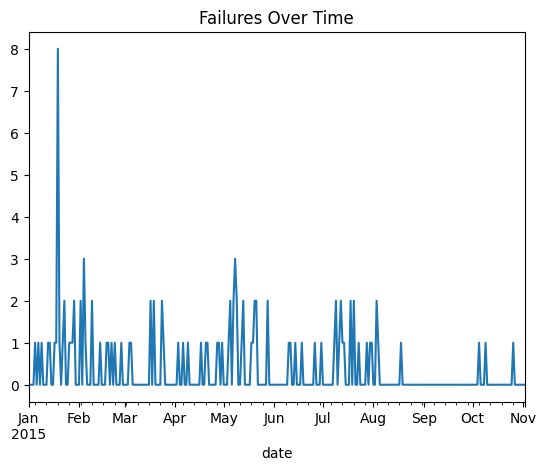

In [12]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date')['failure'].resample('D').sum().plot()
plt.title("Failures Over Time")
plt.show()

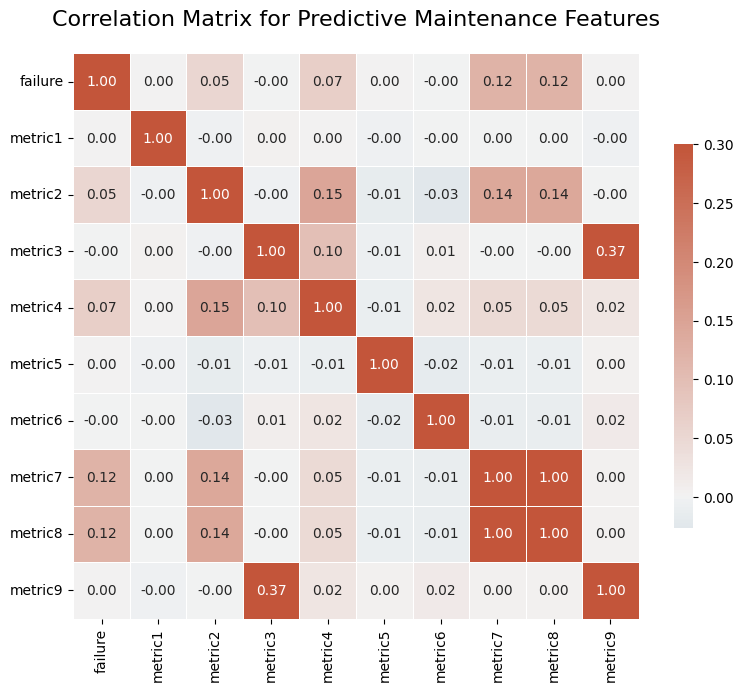

In [13]:
corr_matrix = df[['failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']].corr()
plt.figure(figsize=(8, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .5})
sns.heatmap(corr_matrix, cmap=cmap, vmax=.3, center=0,
             square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for Predictive Maintenance Features', fontsize=16, pad=20)
plt.tight_layout()
#plt.savefig('correlation_matrix.png')
plt.show()


In [14]:
print(df["metric7"]== df["metric8"])

0         True
1         True
2         True
3         True
4         True
          ... 
124489    True
124490    True
124491    True
124492    True
124493    True
Length: 124494, dtype: bool


metric7 and metric 8 might be redundant, metric 8/7 has the strongest correlation also metric 2 and metric 4  might help.
it might be a good idea to remove metrics with low correlation from the dataset before creating the models.


A p-value represents the probability of observing a correlation as strong as the one in your sample (or stronger) if there was actually no correlation in the overall population (i.e., if the null hypothesis is true).
How to interpret p-values:

p < 0.05: Traditionally considered statistically significant. This means there's less than a 5% chance you would observe this correlation if no true relationship exists.
p < 0.01: Strongly significant
p < 0.001: Very strongly significant

t = r * sqrt((n-2)/(1-r²))
- r is the correlation coefficient
- n is the sample size (124494)

In [15]:
import scipy.stats as stats

n = 124494
r = 0.12

# Calculate t-statistic
t = r * math.sqrt((n-2)/(1-r**2))

# Calculate two-tailed p-value
p = 2 * (1 - stats.t.cdf(abs(t), df=n-2))

print(f"t-statistic: {t}")
print(f"p-value: {p}")

t-statistic: 42.648289806000705
p-value: 0.0


the p value is so small that python rounds it to zero.
this mean even the metrics with smallest correlation is statistically significant.

# Preparing data for the ml

In [16]:
# sets date collum to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# redundant metric
df = df.drop('metric8', axis=1)

#creating features that might be usefull
# The specific metrics to use are not determined for now 
# df['metric_ratio_1'] = df['metric2'] / (df['metric1'] + 1)
# df['metric_ratio_2'] = df['metric9'] / (df['metric6'] + 1)

oversampling using smote (Synthetic Minority Over-sampling Technique) to balance failure classes

In [17]:
from imblearn.over_sampling import SMOTE
X = df.drop(['failure', 'device'], axis=1)
y = df['failure']
x, y = SMOTE().fit_resample(X, y)

# Random Forest feature selection

In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x, y)

# Get feature importances
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
top_features = feature_importance.sort_values('Importance', ascending=False)


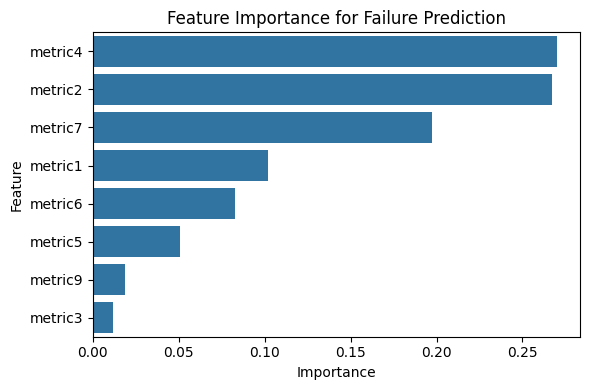

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importance for Failure Prediction')
plt.tight_layout()
plt.show()

# ml

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [34]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = classification_report(y_test, y_pred, output_dict=True)

In [37]:
# def print_results(model_name):
#     report_df = pd.DataFrame(results[model_name]).transpose()
#     print(f"\n=== {model_name} results ===\n")
#     print(report_df.round(3))  

# for key in results.keys():
#     print_results(key)


/tmp/ipykernel_55850/2212429627.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_results, x="Model", y="Score", hue="Metric", ci=None)


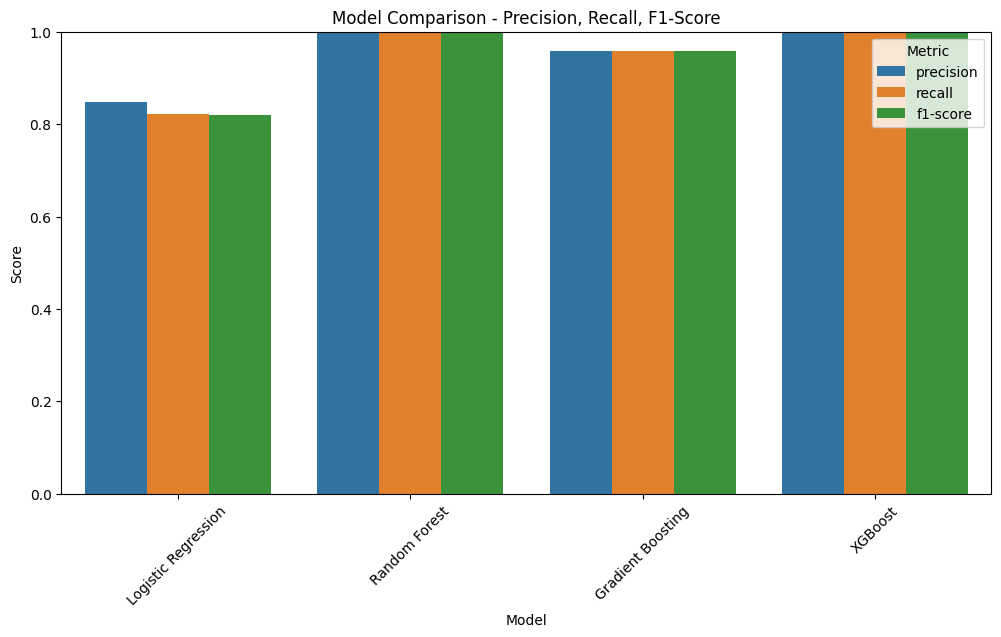

In [35]:
metrics = ['precision', 'recall', 'f1-score']
classes = list(results['Logistic Regression'].keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

data = []
for model_name, report in results.items():
    for cls in classes:
        for metric in metrics:
            data.append({
                'Model': model_name,
                'Class': cls,
                'Metric': metric,
                'Score': report[cls][metric]
            })

df_results = pd.DataFrame(data)

# Plot bar charts
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="Score", hue="Metric", ci=None)
plt.title("Model Comparison - Precision, Recall, F1-Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()